# Barrents sea - CTD data processing

## Introduction
This Notebook provides guidance and support for data processing of CTD data, in particular by making use of the Geostatistical Library (RIntaros / RGeostats) for the modelisation of geostatistical relationships between variables, and to interpolate gridded data maps out of irregular CTD point measurements.

The CTD data access point is configured for the OPeNDAP Hyrax server hosted at NODC: 
http://opendap1.nodc.no/opendap/physics/point/yearly/contents.html 

Note: for this server, the **.nc4** extension from the data access URLs is not supported.

The multi-year selection for CTD campaigns at sea is supported via the **year** parameter in the *fetch_data(url, year)* function in *helpers.py*, and consequently all the *fetch_data(url, year)* function calls within the Notebook. 

Citation: refer to the EC INTAROS project (https://cordis.europa.eu/project/id/727890).

# Exploratory Data Analysis

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os

from helpers import *

## Set-up

### Server URL

In [2]:
# Define URLs of servers  
nodc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' # on NODC server

server_url = nodc_url

### Define Year and Platform Codes 
The information on **year** and **platforms** available on the server (the individual NetCDF files) must be known a priori 

In [3]:
year = 2003 # Define year of interest
platform_codes = ['AA', 'GS', 'GT', 'HJ', 'JH'] # Define codes of platforms of interest

## Retrieval of DDS info
Access data using the dds info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION'

In [4]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

for pc in platform_codes:
    
    dds = f'{server_url}/58{pc}_CTD_{year}.nc.dds'
        
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

#pprint.pprint(pc_dim_dict)
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


## Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

### Create Position_Dict

In [5]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
#     coords_str = 'LONGITUDE[0:1:683]'
#     coords_str = ''
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2003.nc?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2003.nc?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms. 

In [6]:
# Load locations (long & lat) and TIME of ALL measurements
from datetime import datetime, timedelta
start_date = datetime(1950, 1, 1)
    
position_df = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df = position_df.append(test) 
    
position_df['Index_ABS'] = np.arange(0,len(position_df))
position_df = position_df.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df)} measurement locations')
position_df

Platform AA: 684 measurement locations.


,Longitude,Latitude,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude,Latitude,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude,Latitude,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude,Latitude,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude,Latitude,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


In [7]:
# Save dataframe to csv
# position_df.to_csv('all_locations.csv', sep=',', header=True)

### Plot Positions
Plot locations on an interactive plot. 

First, define the dataframe that you would like to plot to the **df_toPlot** variable.

In [144]:
df_toPlot = position_df

Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [145]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook() # necessary to show the plot 

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Platform", "@Platform"),            
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
           title="Mouse over the dots")

# p.square('Longitude', 'Latitude', size=6, color='grey', fill_color='white', source=df_toPlot, legend_label="All locations")
p.circle('Longitude', 'Latitude', size=4, color='red', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='AA'], legend_label="Platform AA locations")
p.circle('Longitude', 'Latitude', size=4, color='blue', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GS'], legend_label="Platform GS locations")
p.circle('Longitude', 'Latitude', size=4, color='green', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GT'], legend_label="Platform GT locations")
p.circle('Longitude', 'Latitude', size=4, color='black', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='HJ'], legend_label="Platform HJ locations")
p.circle('Longitude', 'Latitude', size=4, color='orange', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='JH'], legend_label="Platform JH locations")

# Add area
# p.quad(left=bbox[0], right=bbox[1], top=bbox[3], bottom=bbox[2], legend_label="Bounding Box", fill_color='grey', fill_alpha=0.0, line_color="black")

p.legend.location = "bottom_right"
show(p)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

## Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the 'LATITUDE', 'LONGITUDE' and 'TIME' dimensions. The following filters are included:
* filter by bounding box (BBOX)
* filter by BBOX and customised time range 

### Filter by BBOX

In [146]:
# Now apply the arctic bounding box in the format: minLong - maxLong; minLat - maxLat (eg 30W - 60E; 50N - 80 N) 
bbox_dict = {}

bbox_dict['BBOX=ALL'] = [-20, 70, 40, 90] 
bbox_dict['BBOX=Arctic'] = [-30, 60, 50, 80]  
bbox_dict['BBOX=North Sea'] = [-5, 15, 50, 60]

bbox_key = 'BBOX=North Sea'; assert bbox_key in bbox_dict.keys(), 'Key error, please check.' 
bbox = bbox_dict[bbox_key]

In [147]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox[3])]
print('Year:', year)
print('BBOX:', bbox_key)

sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox)
#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

Year: 2003
BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


### Filter by BBOX and Time Range

In [183]:
# Define start and end date in the format [day,month,year]
"""
# time range test for GT
time_start = [1,9,2003] # for GT
time_end = [30,9,2003] # for GT
"""
# time range test for AA
time_start = [1,1,2003] # for AA
time_end = [31,1,2003] # for AA

time_start = datetime(time_start[2], time_start[1], time_start[0])
time_end = datetime(time_end[2], time_end[1], time_end[0])

time_filter_str = f'{time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}'
print(f'Time Filter: {time_filter_str}')

position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]
display(position_df_bbox_timerange)

Time Filter: 2003-01-01 - 2003-01-31


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
107,4.1780,58.313202,2003-01-26 19:55:12,AA,107
108,3.1493,59.717300,2003-01-27 07:44:14,AA,108
109,2.7527,59.630299,2003-01-27 10:41:34,AA,109


# Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables accessing data of **only the selected variable** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Test 1

### Define Parameters

In [184]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variables to use for the analysis (PS use brakets also with only one var, eg ['TEMP'])
vars_sel = ['TEMP']; assert all([elem in vars_main for elem in vars_sel])

### Define Platform Code

In [185]:
pc = 'AA'; assert pc in position_dict.keys(); # platform code

### Define DEPTH

In [186]:
depth = 3

### Create **data_dict** dictionary 
Once variables are defined, the DEPTH range must be defined. 

**INSERT BELOW** the desired DEPTH range (in meters) in the two fields of hte following cell, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

Once the variables and DEPTH range are defined, data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

In [187]:
data_dict = {}
metadata = {}

metadata[pc] = {}

v_min = int(float(position_dict[pc]['data_attr'][6]))
metadata[pc]['vmin'] = v_min
metadata[pc]['depth_abs_v1'] = 0 # this is fixed
metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

# ==============================================================================
"""
Define here the DEPTH range of your selection, in meters. Note that either:
- 'depth_m_v1' is equal to the lower bound (ie index=0), or 
- 'depth_m_v2' is equal to the upper bound (ie index=-1)
"""
metadata[pc]['depth_m_v1'] = 0
metadata[pc]['depth_m_v2'] = depth #pc_dim_dict[pc]['DEPTH'] 
# ==============================================================================

# assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
# assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

#     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

# the start and stop values are adjusted based on the vmin value
if metadata[pc]['vmin'] == 1: 
    if metadata[pc]['depth_m_v1'] == 0: # 
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
        metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

    elif metadata[pc]['depth_m_v1'] != 0: 
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
        metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

else:
    metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
    metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

    if metadata[pc]['depth_m_v1'] == 0: # 
        metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

    elif metadata[pc]['depth_m_v1'] != 0: 
        metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

metadata[pc]['depth_newindex4xr_v1'] = 0

pprint.pprint(metadata[pc])
print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

# Get coordinates (needed for keeping hte correct structure, and for plotting) 
coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

# Extract TIME and DEPTH dimension for queries 
time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

# join TIME and DEPTH for Variables
var_str_ALL = []
for var in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{var}{time_dims}{depth_dims}')
queries_vars = ','.join(var_str_ALL)

# Build url and url with queries (url_q)
url = f'{server_url}{fix_lab}.nc?{coords_str}' 
url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

remote_data, data_attr = fetch_data(url_q, year)

data_dict[pc] = {'data': remote_data, 
                 'data_attr': data_attr}

print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 3,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 3,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 3,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 3
Platform AA URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:3]
['58AA' 'H\\303\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

Checking the existing campaigns in the dictionary: ['AA']


### Create Overview Dataframe with Platforms' Attributes
An overview dataframe overview_df is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [188]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\303\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999


In [189]:
# Extract / define the variables to use for the analysis
for key in data_dict.keys():
    print(key, list(data_dict[key]['data'].variables))
    
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in metadata.keys():
    print(f' - Pl. {k}; Available DEPTH range: {metadata[k]["depth_m_v1"]} - {metadata[k]["depth_m_v2"]} meters.')

AA ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']

Printing DEPTH range for analyis:
 - Pl. AA; Available DEPTH range: 0 - 3 meters.


In [190]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{}

### Define Filtered Data (*df_toPlot*)
Define the filtered dataframe to use for the analysis (eg *position_df_bbox*, *position_df_bbox_mm*, *position_df_bbox_hh*) to the **df_toPlot** variable.

In [191]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange
print('BBOX:', bbox_key)

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(df_toPlot)

BBOX: BBOX=North Sea
Selected positions (out of available positions): 87 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
107,4.1780,58.313202,2003-01-26 19:55:12,AA,107
108,3.1493,59.717300,2003-01-27 07:44:14,AA,108
109,2.7527,59.630299,2003-01-27 10:41:34,AA,109


In [192]:
# find indices for each platform for the selected data
index = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

# Filer data using the indexes of the filtered elements
data_dict[pc]['data'].isel(TIME=index,
                           LATITUDE=index,
                           LONGITUDE=index)
#                            DEPTH=slice(depth, depth+1))

<xarray.Dataset>
Dimensions:    (DEPTH: 4, LATITUDE: 87, LONGITUDE: 87, TIME: 87)
Coordinates:
  * TIME       (TIME) float64 1.937e+04 1.937e+04 ... 1.939e+04 1.939e+04
  * LATITUDE   (LATITUDE) float32 59.28 59.28 59.28 59.28 ... 59.63 59.7 59.67
  * LONGITUDE  (LONGITUDE) float32 -0.9848 -0.6563 -0.3618 ... 1.274 0.8155
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 ...
Attributes: (12/152)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          2810

### Data Filtering by DEPTH
This section allows filtering the xarray data using the selected DEPTH, as well as the data previously filtered based on BBOX and time range (Filtered Position section)

The output of this operation is a *filtered_xarr* xarray dataset, containing one variable at the specified DEPTH. 

#### Data filtered by BBOX and One Variable

In [194]:
# Generate a filtered xarray with one single VAR for selected Platform, for a certain DEPTH range

if metadata[pc]['depth_m_v1']==0: align_and_nan = True
else: align_and_nan = False
check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)

filtered_xarr = filter_xarr_DEPTH(df_toPlot, 
                                  data_dict,
                                  platform=pc,
                                  depth_range=[depth, depth])
display(filtered_xarr)

Platform: AA - Vertical min = 0.0


<xarray.Dataset>
Dimensions:    (DEPTH: 1, LATITUDE: 87, LONGITUDE: 87, TIME: 87)
Coordinates:
  * TIME       (TIME) float64 1.937e+04 1.937e+04 ... 1.939e+04 1.939e+04
  * LATITUDE   (LATITUDE) float32 59.28 59.28 59.28 59.28 ... 59.63 59.7 59.67
  * LONGITUDE  (LONGITUDE) float32 -0.9848 -0.6563 -0.3618 ... 1.274 0.8155
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 8.087 7.567 7.354 ... 7.908 7.654 7.493
Attributes: (12/152)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          2810

### Plotting VAR vs TIME at specific DEPTH
On the y-axis is shown the TIME of the measurement (in *float* format, which needs to be converted to *datetime* format), and on the x-axis is the DEPTH of the measurement.

Var to plot: TEMP


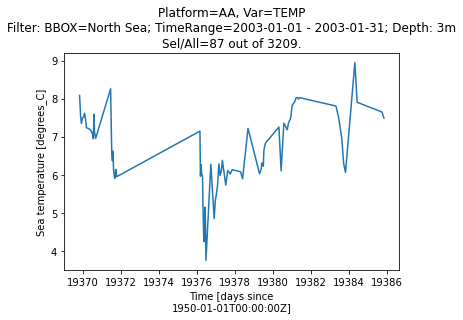

In [195]:
print(f"Var to plot: {var}")

title = f'Platform={pc}, Var={var}\nFilter: {bbox_key}; TimeRange={time_filter_str}; Depth: {depth}m\nSel/All={sel_outof_all}'

plotFilteredVar(filtered_xarr[var], title=title)

### Export to CSV


In [196]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv = pd.DataFrame() 

for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
    filtered2csv[col.title()] = filtered_xarr[col].data.astype(float) 
filtered2csv['Temperature'] = filtered_xarr['TEMP'].data.astype(float) 
filtered2csv['Depth'] = depth 
filtered2csv['PlatformCode'] = pc 

display(filtered2csv)

,Longitude,Latitude,Time,Temperature,Depth,PlatformCode
0,-0.9848,59.284801,19369.830231,8.087,3,AA
1,-0.6563,59.284801,19369.882118,7.567,3,AA
2,-0.3618,59.284801,19369.925961,7.354,3,AA
3,0.0065,59.281700,19369.979792,7.483,3,AA
4,0.3293,59.284698,19370.039549,7.527,3,AA
...,...,...,...,...,...,...
82,4.1780,58.313202,19383.830000,6.070,3,AA
83,3.1493,59.717300,19384.322384,8.947,3,AA
84,2.7527,59.630299,19384.445532,7.908,3,AA
85,1.2742,59.701698,19385.749734,7.654,3,AA


In [197]:
# Save dataframe to csv
data_dir = os.path.join(os.getcwd(), 'data')
if not os.path.exists(data_dir): os.mkdir(data_dir)
    
csvname = os.path.join(data_dir, f'filtered_{pc}_{var}_{depth}m.csv')

filtered2csv.to_csv(csvname, sep=',', header=True)

## INTAROS - IMR Dataset - Case Study
### Install R Kernel & Testing

In [198]:
!pip install rpy2

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Definition of the environment

The next cells have specific contents that the user must choose to run or to skip. Their order is important.

- Loading the library **Intaros**

In [199]:
%%R 
suppressWarnings(suppressPackageStartupMessages(library(RIntaros)))

# Cleaning the workspace: this paragraph is not systematically performed.
rm(list=ls())

# Defining if the data set must be read or not from the CSV (flag.read)
flag.read = FALSE

### Loading Data

First of all, we setup some environment variables (data file name and bounding box).
The **flag_file** allows the user to store each generated graphic file as a **PNG** file in the **image_name** directory, instead of plotting them.

In [252]:
%%R 
# Setup environment
dir.name   = getwd()
file.name  = 'filtered_AA_TEMP_3.csv'
data.name  = 'data'
long_lim   = c(-5,15)
lat_lim    = c(50,60)

intaros.save.environ(long_lim = long_lim, lat_lim = lat_lim,
                     flag_file = FALSE)#, image_name = file.path(dir.name,image.name))

Then we read the **CSV** file (taking the header line into account) and create the RGeostats Db. Finally we show the contents of the newly created Db (named **db0**).

In [257]:
%%R
depth = 3
var = "Temperature"

In [202]:
%%R 
if (flag.read || ! exists("db0")) db0 = imr_read_csv(file.path(dir.name,data.name,file.name))
db0


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of fields             = 7
Maximum Number of attributes = 7
Total number of samples      = 87

Variables
---------
Field =   1 - Name    =  rank - Locator =  NA
Field =   2 - Name    =  X - Locator =  NA
Field =   3 - Name    =  Longitude - Locator =  x1
Field =   4 - Name    =  Latitude - Locator =  x2
Field =   5 - Name    =  Time - Locator =  NA
Field =   6 - Name    =  Temperature - Locator =  NA
Field =   7 - Name    =  Depth - Locator =  NA


### Dataset global statistics

We first establish the time amplitude of the dataset, as well as a set of colors assigned to each year.

In [203]:
%%R
years      = subyears = get_db_limits_year(db0)
trimesters = subtrims = seq(1,4)
colyears   = rg.colors(length(years))
cat(build_title("The dataset period is:",time2date(get_db_limits_time(db0))))

The dataset period is: (2003-01-12 => 2003-01-28)

Let us get some statistics on the information available

In [204]:
%%R
db.stat.print(db0,funs=c("num","mini","maxi","mean"),
              names=c("Longitude","Latitude","Depth","Temperature","Conductivity","Salinity"))

               Number   Minimum   Maximum      Mean
Longitude          87    -1.466     8.556     3.909
Latitude           87    56.676    59.717    58.058
Depth              87     3.000     3.000     3.000
Temperature        87     3.769     8.947     6.681



### Studying Temperature variable

From this point, most of the calculations will be performed based on the **Temperature** variable.

#### All Database

We display all samples focusing on the variable in a 2D aerial view, reporting the country borders. For comparison, we define a common color scale, established on the global minimum and maximum values (**var_scale0**).
Note that all samples from all years and all depths are displayed (slow operation).

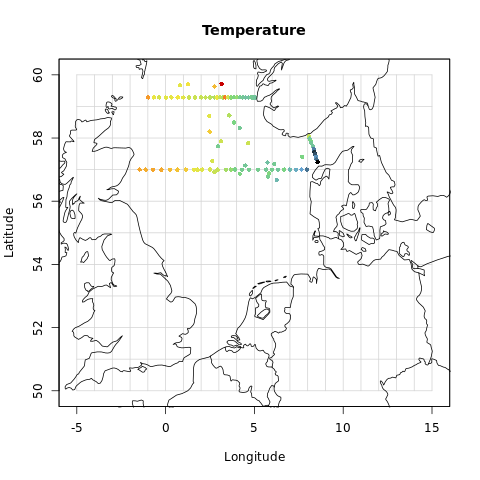

In [258]:
%%R
colors.temp = rg.colors(rank=1)
var_scale0 = get_db_limits_var(db0,var)
display_var(db0, var = var, colors = colors.temp, title = var, filename = var)

#### Year Campaign

We display Temperature values for the year 1995 only.

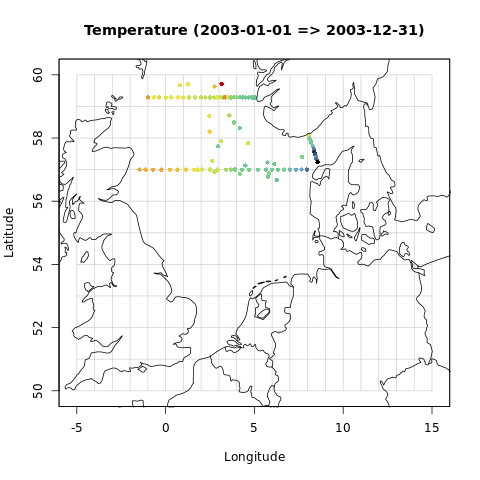

In [259]:
%%R

# Comment the following line if you want to to display all years
subyears = years[1]

# Loop on the years to be displayed
for (year in subyears) 
{
  date_lim  = create_limits_date(year)
  db        = apply_sel(db0, date_lim=date_lim)
  filename  = paste0(var,"_Year_",year)
  title     = build_title(var, date_lim)
  display_var(db, var, var_scale = var_scale0, colors = colors.temp, 
              title = title, filename = filename)
}

#### Year/Trimester at 20m Depth

Display data for the first trimester of the year 1995 focusing on data at 20m depth exactly.

In [260]:
%%R
trimesters

[1] 1 2 3 4


In [261]:
%%R
subyears = years[1]
subtrims = trimesters[1]
subtrims

[1] 1


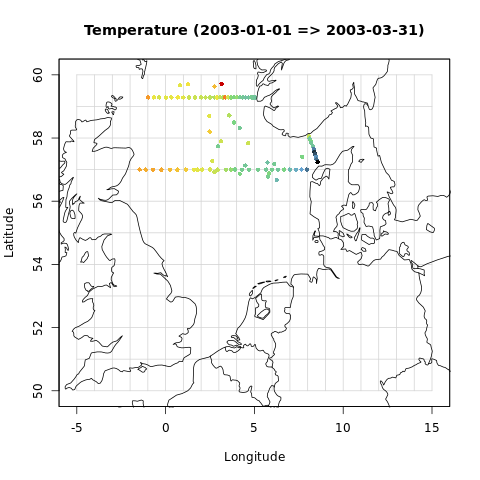

In [262]:
%%R

# Select samples at depth 20m and set the color scale
db1       = apply_sel(db0, depth_lim=c(depth,depth), compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following lines if you want to display all trimesters / years
subyears = years[1]
subtrims = trimesters[1]

# Loop on the years / trimesters to be displayed
for (year in subyears) 
  for (itri in subtrims)
  {
    date_lim  = create_limits_date(year, trimester=itri)
    db        = apply_sel(db1,date_lim=date_lim)
    filename  = paste0(var,"_Trim_",year,"_T",itri)
    title     = build_title(var, date_lim)
    display_var(db, var,  var_scale = var_scale, colors = colors.temp,
                title = title, filename = filename)
  }

#### Block Average at 20m Depth

The next display considers the variable (at 20m depth exactly) averaged over the cells of a coarse grid (mesh of 1 degree).

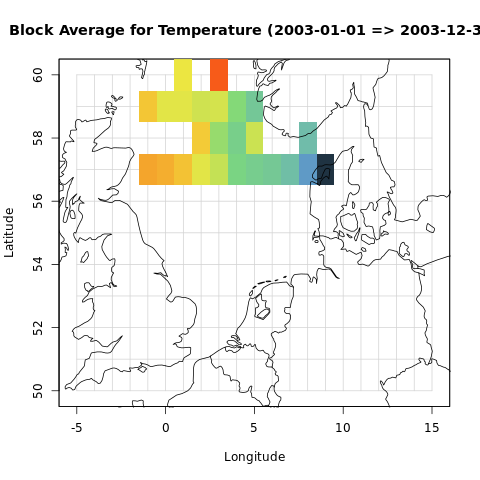

In [263]:
%%R
var = "Temperature"

# Select samples at depth 20m and set the color scale
db1       = apply_sel(db0, depth_lim=c(depth,depth),compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following line if you want to to display all years
subyears = years[1]

# Loop on the years
for (year in subyears) 
{
  date_lim  = create_limits_date(year)
  db        = apply_sel(db1, date_lim=date_lim)
  filename  = paste0(var,"_Mean_",year)
  title     = paste("Block Average for", build_title(var, date_lim))
  dbg       = stats_grid(db, var, fun = "mean", mesh = 1)
  display_stats(dbg, var, var_scale = var_scale, colors = colors.temp,
                title = title, filename = filename)
}

### Restriction of the area of interest

In the next operations, we focus on a restricted area. The new Db will be called **dbloc**.

In [264]:
%%R
# Focus to South West of Norway (new global environement)
long_lim = c(0,5)
lat_lim  = c(55,60)
dbloc    = apply_sel(db0, long_lim = long_lim, lat_lim = lat_lim, compress = TRUE)
intaros.save.environ(long_lim = long_lim, lat_lim  = lat_lim)

#### Histogram of Measurement Depths

We also aggregate the values of all samples vertically from 0m by 10 steps of 10m.
Then, we can double-check this regularization step by plotting the histogram of the initial depths and the histogram of the depths in the aggregated file.

In [265]:
# %%R
# # Aggregate along depth from 0 to 100m, by steps of 10m
# dbreg = aggregate_depth(dbloc, depth0 = 0, ddepth = 10, ndepth = 10, flag.center = TRUE)

# # Histogram of depths
# hist(dbloc[,"Depth"],breaks=100,xlab="Initial Depth",main="")
# hist(dbreg[,"Depth"],breaks=100,xlab="Regular Depth",main="")

## Statistics per Year

Calculate the mean and the variance of the Temperature for each year, starting from the depth-aggregated data. We focus on the samples located at 25m depth. We can compare the mean and variance to the one calculated on the initial data (before aggregation)

In [268]:
%%R 
# Focus at DEPTH exactly
depth_lim = c(depth,depth)
dbc       = apply_sel(dbloc, depth_lim = depth_lim, compress = TRUE)
dbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = TRUE)

# Average Temperature along time (by year) at 25m depth
cres      = average_time(dbc, var, years)
rres      = average_time(dbr, var, years)

# Display means
plot (years,rres$means,type="b",main=paste("Mean of",var,"at",depth,"m"),pch=15,lty=1,col=colyears)
lines(years,cres$means,type="b",pch=19,lty=2,col=colyears)
legend("topleft",legend=c("Initial","Aggregated"),lty=c(2,1),pch=c(19,15))

# Display variances
plot (years,rres$vars ,type="b",main=paste("Variance of",var,"at",depth,"m"),pch=15,lty=1,col=colyears)
lines(years,cres$vars ,type="b",pch=19,lty=2,col=colyears)
legend("topleft",legend=c("Initial","Aggregated"),lty=c(2,1),pch=c(19,15))

# Store the maximum variance for further use
varmax = 1.2 * max(rres$vars)

R[write to console]: Error in attach(db[], warn.conflicts = FALSE) : object 'dbreg' not found

R[write to console]: Error in detach(db[]) : invalid 'name' argument




Error in detach(db[]) : invalid 'name' argument


RInterpreterError: Failed to parse and evaluate line '# Focus at DEPTH exactly\ndepth_lim = c(depth,depth)\ndbc       = apply_sel(dbloc, depth_lim = depth_lim, compress = TRUE)\ndbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = TRUE)\n\n# Average Temperature along time (by year) at 25m depth\ncres      = average_time(dbc, var, years)\nrres      = average_time(dbr, var, years)\n\n# Display means\nplot (years,rres$means,type="b",main=paste("Mean of",var,"at",depth,"m"),pch=15,lty=1,col=colyears)\nlines(years,cres$means,type="b",pch=19,lty=2,col=colyears)\nlegend("topleft",legend=c("Initial","Aggregated"),lty=c(2,1),pch=c(19,15))\n\n# Display variances\nplot (years,rres$vars ,type="b",main=paste("Variance of",var,"at",depth,"m"),pch=15,lty=1,col=colyears)\nlines(years,cres$vars ,type="b",pch=19,lty=2,col=colyears)\nlegend("topleft",legend=c("Initial","Aggregated"),lty=c(2,1),pch=c(19,15))\n\n# Store the maximum variance for further use\nvarmax = 1.2 * max(rres$vars)\n'.
R error message: "Error in detach(db[]) : invalid 'name' argument"

## Statistics per Depth 

Consider year 2008 and evaluate the mean and variance of the Temperature per depth level (every 10m). Calculations are performed starting from the initial data set.

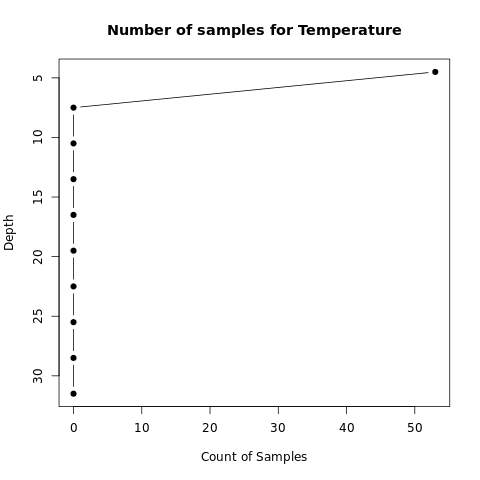

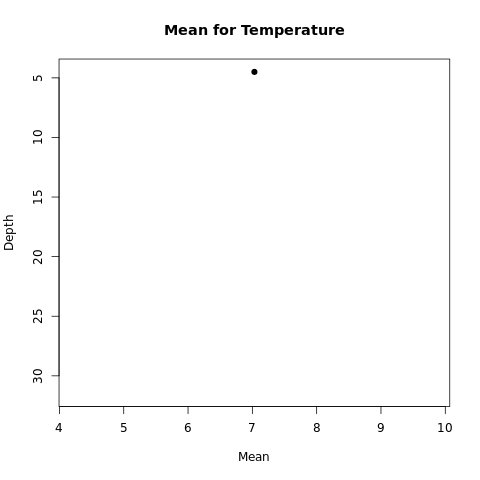

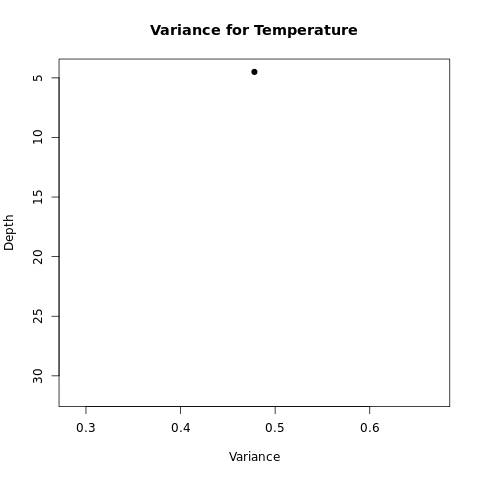

In [274]:
%%R
# Average Temperature by depth
date_lim  = create_limits_date(year)
db1       = apply_sel(dbloc, date_lim = date_lim, compress = TRUE)
res       = average_depth(db1, var, depth0 = 0, ddepth = depth, ndepth = 10)

# Display statistics
plot(res$count,res$depths,type="b",main=paste("Number of samples for",var),pch=19,
     xlab="Count of Samples", ylab="Depth", ylim=rev(range(res$depths)))
plot(res$means,res$depths,type="b",main=paste("Mean for",var),pch=19,
     xlab="Mean", ylab="Depth", ylim=rev(range(res$depths)))
plot(res$vars ,res$depths,type="b",main=paste("Variance for",var),pch=19,
     xlab="Variance", ylab="Depth", ylim=rev(range(res$depths)))

## Regularization along Time

Starting from the initial data base, regularize the Temperature every 30 days by calcuting its mean for each interval

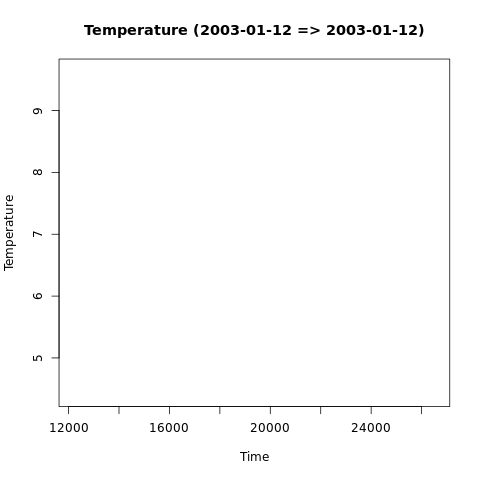

In [275]:
%%R
# Regularize Temperature along Time
dbg = regular_time(dbloc, var, time_step = 30)

# Display regularized 1-D database along time
plot(dbg, title = build_title_db_time(dbg,var), xlab = "Time", ylab = var)

## Regularization along Depth

Starting from the initial data base, regularize the Temperature every 2m depth

In [276]:
%%R 
# Regularize Temperature along Depth
dbg = regular_depth(dbloc, var, depth_step = 2)

# Display regularized 1-D database along depth
plot(dbg, title=build_title_db_depth(dbg,var), xlab="Depth", ylab = var)

R[write to console]: Error in data.frame(..., check.names = FALSE) : 
  arguments imply differing number of rows: 2, 0, 3




Error in data.frame(..., check.names = FALSE) : 
  arguments imply differing number of rows: 2, 0, 3


RInterpreterError: Failed to parse and evaluate line '# Regularize Temperature along Depth\ndbg = regular_depth(dbloc, var, depth_step = 2)\n\n# Display regularized 1-D database along depth\nplot(dbg, title=build_title_db_depth(dbg,var), xlab="Depth", ylab = var)\n'.
R error message: 'Error in data.frame(..., check.names = FALSE) : \n  arguments imply differing number of rows: 2, 0, 3'

## Horizontal Variogram per Year

Review the horizontal variograms for different years at 25m depth, calculated from the aggregated data set.

In [277]:
%%R
# Define the active samples
depth_lim = c(depth,depth)
dbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = TRUE)
dbr       = db.locate(dbr,var,"z")

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Loop on the years
ecr = 1
add = FALSE
for (year in years) 
{
  date_lim = create_limits_date(year)
  dbr = remove_sel(dbr)
  dbr = apply_sel(dbr, date_lim = date_lim)

  vario = prepar_vario(dbr, dirvect=NA, 
                       vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario=TRUE,
                       add=add, ylim=c(0,varmax), col=colyears[ecr], lwd=1,
                       varline=FALSE, npairdw=TRUE)

  ecr = ecr + 1
  add = TRUE
}
legend("right",legend=years,col=colyears,lty=1,lwd=2,cex=0.8)

R[write to console]: Error in attach(db[], warn.conflicts = FALSE) : object 'dbreg' not found

R[write to console]: Error in detach(db[]) : invalid 'name' argument




Error in detach(db[]) : invalid 'name' argument


RInterpreterError: Failed to parse and evaluate line '# Define the active samples\ndepth_lim = c(depth,depth)\ndbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = TRUE)\ndbr       = db.locate(dbr,var,"z")\n\n# Variogram parameters\nvario_lag  = 1\nvario_nlag = 20\n\n# Loop on the years\necr = 1\nadd = FALSE\nfor (year in years) \n{\n  date_lim = create_limits_date(year)\n  dbr = remove_sel(dbr)\n  dbr = apply_sel(dbr, date_lim = date_lim)\n\n  vario = prepar_vario(dbr, dirvect=NA, \n                       vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario=TRUE,\n                       add=add, ylim=c(0,varmax), col=colyears[ecr], lwd=1,\n                       varline=FALSE, npairdw=TRUE)\n\n  ecr = ecr + 1\n  add = TRUE\n}\nlegend("right",legend=years,col=colyears,lty=1,lwd=2,cex=0.8)\n'.
R error message: "Error in detach(db[]) : invalid 'name' argument"

## Cross-Validation

We first perform a cross-validation step

In [278]:
%%R 
# Define the active samples
depth_lim = c(depth,depth)
date_lim  = create_limits_date(year, trimester=2)
dbr       = apply_sel(dbreg, depth_lim = depth_lim, date_lim = date_lim, compress = TRUE)

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Perform the Cross-validation (includes Variogram calculation and Model fitting)
dbp = xvalid_2D(dbr, var,  
                vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                dirvect = NA, draw.model=TRUE, radix="Xvalid")
db.stat.print(dbp,names="Xvalid*",funs=c("num","mean","var"),title="Cross-Validation Scores")

# Display the results
filename  = paste0("Xvalid_",var)
display_var(dbp, var = "*stderr", flag.xvalid = TRUE, colors = rainbow(100),
            title = var, filename = filename, pos.legend=7)

R[write to console]: Error in attach(db[], warn.conflicts = FALSE) : object 'dbreg' not found

R[write to console]: Error in detach(db[]) : invalid 'name' argument




Error in detach(db[]) : invalid 'name' argument


RInterpreterError: Failed to parse and evaluate line '# Define the active samples\ndepth_lim = c(depth,depth)\ndate_lim  = create_limits_date(year, trimester=2)\ndbr       = apply_sel(dbreg, depth_lim = depth_lim, date_lim = date_lim, compress = TRUE)\n\n# Variogram parameters\nvario_lag  = 1\nvario_nlag = 20\n\n# Perform the Cross-validation (includes Variogram calculation and Model fitting)\ndbp = xvalid_2D(dbr, var,  \n                vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), \n                dirvect = NA, draw.model=TRUE, radix="Xvalid")\ndb.stat.print(dbp,names="Xvalid*",funs=c("num","mean","var"),title="Cross-Validation Scores")\n\n# Display the results\nfilename  = paste0("Xvalid_",var)\ndisplay_var(dbp, var = "*stderr", flag.xvalid = TRUE, colors = rainbow(100),\n            title = var, filename = filename, pos.legend=7)\n'.
R error message: "Error in detach(db[]) : invalid 'name' argument"

## 2-D Estimation of Temperature

We interpolate the Temperature for the second trimester of year 2008, at the depth of 25m. This interpolation starts from the aggregated data.

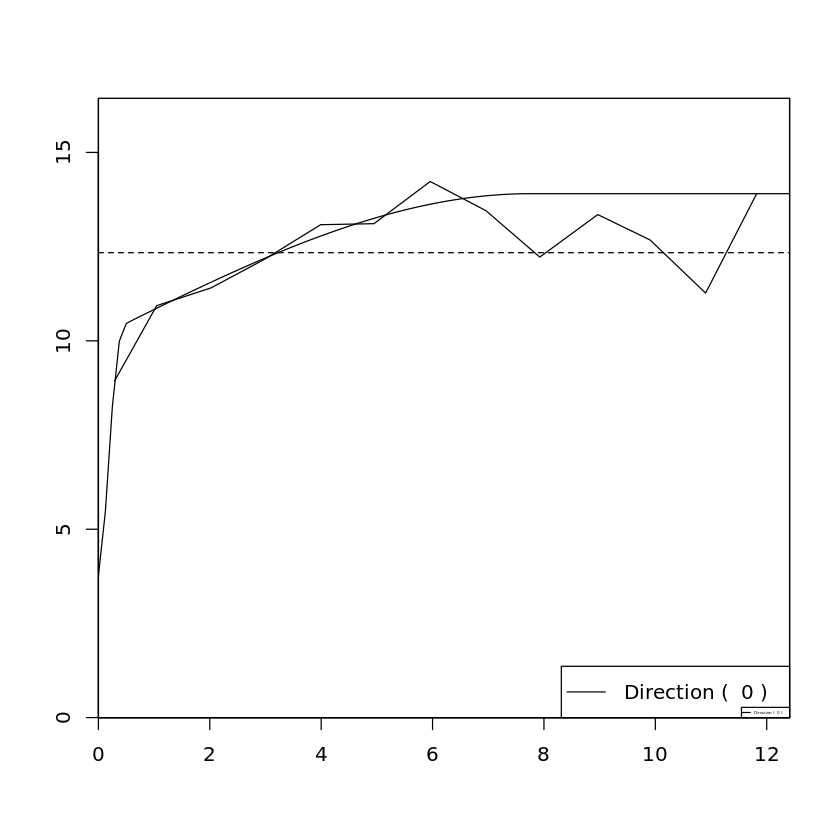

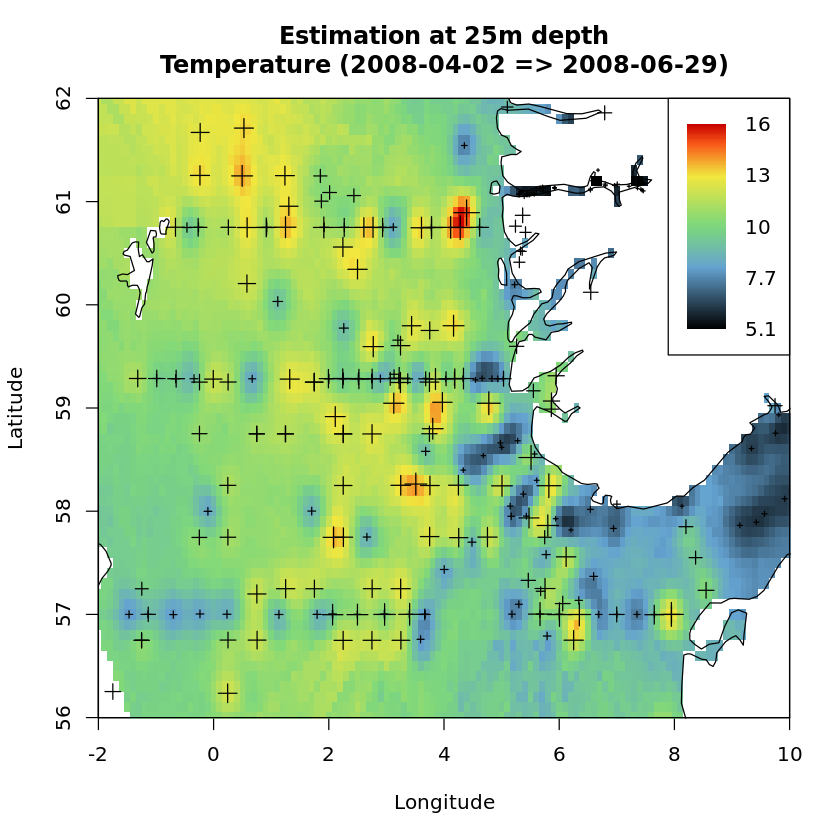

In [59]:
var       = "Temperature"
year      = 2008
depth     = 25

# Select the active samples
depth_lim = c(depth,depth)
date_lim  = create_limits_date(year, trimester=2)
dbr       = apply_sel(dbreg, depth_lim = depth_lim, date_lim = date_lim, compress = TRUE)

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(dbr, var, mesh = 0.1, 
                     vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                     dirvect = NA, draw.model=TRUE, pos.legend=1)

# Display the results
filename  = paste0(var,".Estim2D_Year_",year)
display_result(dbr, dbg, var = var, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, filename = filename, pos.legend=7)

## Moving Neighborhood

Using the moving neighborhood instead (same environment)

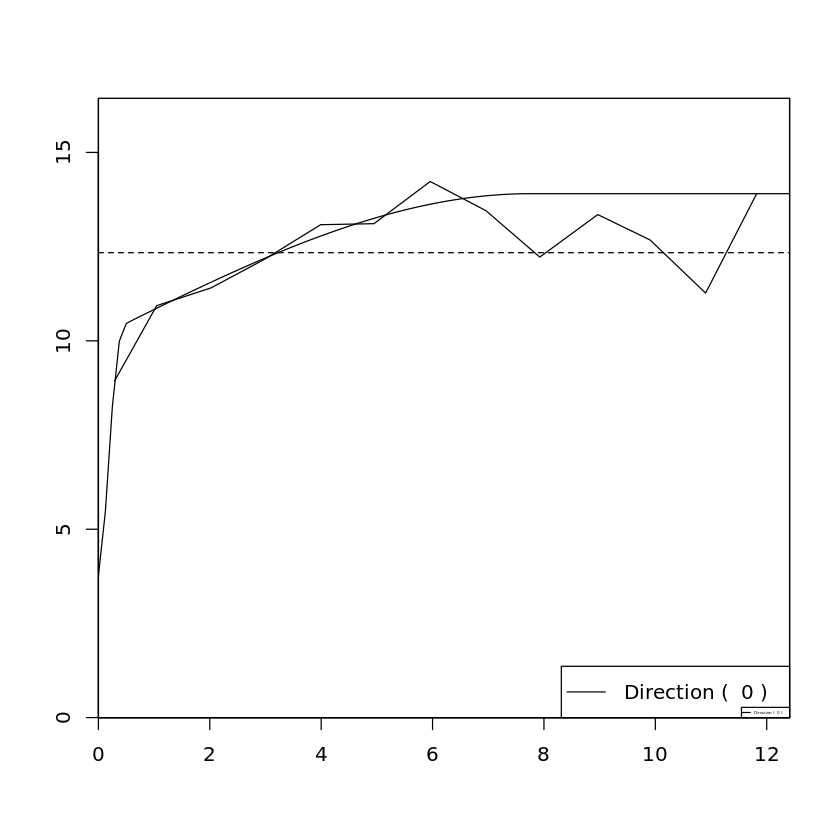

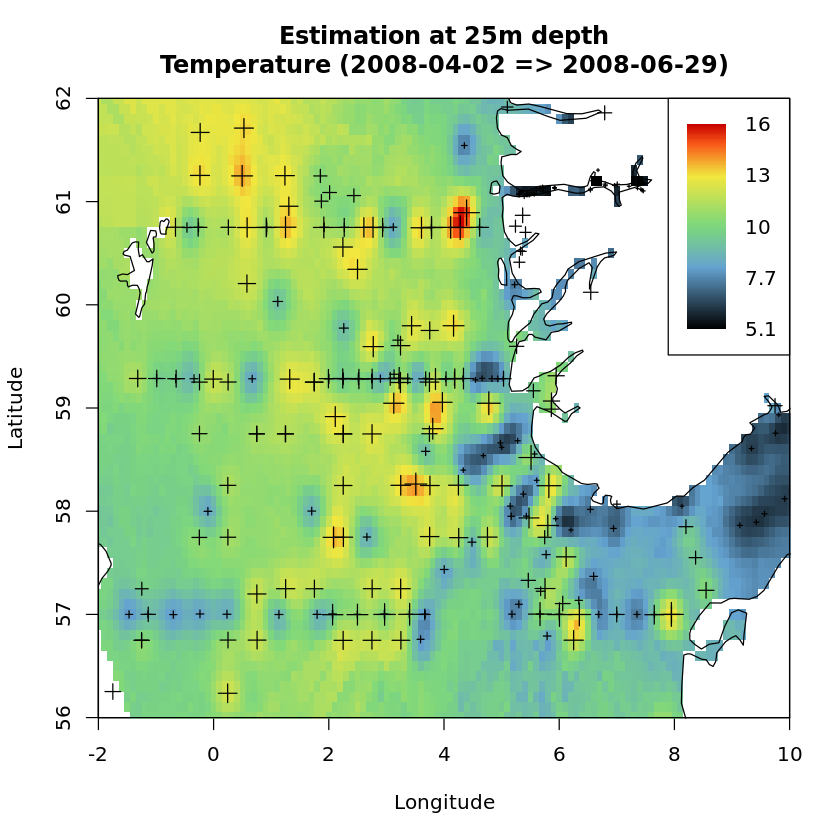

In [60]:
var       = "Temperature"
year      = 2008
depth     = 25

# Select the active samples
depth_lim = c(depth,depth)
date_lim  = create_limits_date(year, trimester=2)
dbr       = apply_sel(dbreg, depth_lim = depth_lim, date_lim = date_lim, compress = TRUE)

# Variogram parameters
vario_lag  = 1
vario_nlag = 20

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(dbr, var, mesh = 0.1, moving = TRUE,
                     vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                     dirvect = NA, draw.model=TRUE, pos.legend=1)

# Display the results
filename  = paste0(var,".Estim2D_M_Year_",year)
display_result(dbr, dbg, var = var, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, filename = filename, pos.legend=7)

# Studying Salinity variable